# Kickstarter Projects

## 目的変数：stateを2値に変換したstate_numを求める
### 【成功（successful）するか、失敗（failed）するか】

# ☆検討経緯
## 【DAY1】
### 量的変数のみを用いてロジスティック回帰を実装。
### 結果、pledgedやbackersを説明変数に用いると正答率が異常に高い結果となった。
### クラウドファンディングの特性からpledgedやbackersを用いるのは不適切だと考えた。
## 【DAY2】
### 他の説明変数が使えないか検討し、新しい特徴量を作成
### pledged / goalとし、資金調達率と定義
### launchedを曜日に変換し、dayofweek_xxxと定義
### deadline - launchedとし、期間と定義
### ステップワイズ法による特徴選択
### ホールドアウト法/交差検証
### アルゴリズムの変更（ロジスティック回帰→SVM）
### グリッドサーチで最適なパラメータ探索
## 最終的に選択した説明変数：dayofweek_Monday,	dayofweek_Tuesday,	dayofweek_Wednesday,	dayofweek_Saturday,	target growth rate

# ☆結果比較
## ロジスティック回帰
### Cross Validation 対数尤度 = -10.745
### Cross Validation 正答率 = 68.89
## SVM-rbf
### 識別精度= 0.9998793242156074

|  カラム  |  意味  |  単位  |
| ---- | ---- | ---- |
|  ID  |  キックスタータID  |  index  |
|  name  |  プロジェクト名  |    |
|  category  |  カテゴリ  |    |
|  main_category  |  キャンペーンのカテゴリ  |    |
|  currency  |  支援通貨  |    |
|  deadline  |  クラウドファンディングの締切  |    |
|  goal  |  資金調達目標 - 作成者がプロジェクトを完了するために必要な金額  |    |
|  launched  |  開始日  |    |
|  pledged  |  「群衆」が約束した金額  |    |
|  state  |  プロジェクトの現状  |    |
|  backers  |  支持者の数  |    |
|  country  |  国  |    |
|  usd pledged  |  USドル換算額 (conversion made by KS)  |    |
|  usd_pledged_real  |  USドル換算額 (conversion made by fixer.io api)  |    |
|  usd_goal_real  |  目標額USドル (conversion made by fixer.io api)  |    |
|  target growth rate  |  資金調達率（pledged / goal） |  %  |
|  period  |  期間（deadline - launched） |  日  |

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns
import sklearn.preprocessing as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV

In [2]:
# 初期設定変更
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

In [3]:
# データ読込
df_cloud = pd.read_csv(
    "./input/ks-projects-201801.csv", dtype = None, delimiter = ",")[
    ['category', 'main_category', 'currency', 'goal', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launched', 'deadline']]

In [4]:
#目的変数の把握
print(df_cloud['state'].value_counts(dropna=False))
print(df_cloud['state'].value_counts(normalize=True, dropna=False))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: state, dtype: float64


canceled/undefined/live/suspendedは予測対象から除外

In [5]:
#成功と失敗の二値に分類

#stateを文字列から数値型へ
def statetype(in_string):
    if in_string == "successful":
        return 0
    elif in_string == "failed":
        return 1
    else :
        pass
        
df_cloud['state_num']= df_cloud['state'].apply(statetype)

In [6]:
#欠損値データを削除
df_cloud.dropna(inplace=True)

In [7]:
df_cloud['dayofweek'] = pd.to_datetime(df_cloud['launched']).dt.strftime('%A')
#df_cloud['dayofweek'] = pd.to_datetime(df_cloud['launched']).dt.dayofweek
df_cloud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331465 entries, 0 to 378660
Data columns (total 15 columns):
category            331465 non-null object
main_category       331465 non-null object
currency            331465 non-null object
goal                331465 non-null float64
pledged             331465 non-null float64
state               331465 non-null object
backers             331465 non-null int64
country             331465 non-null object
usd pledged         331465 non-null float64
usd_pledged_real    331465 non-null float64
usd_goal_real       331465 non-null float64
launched            331465 non-null object
deadline            331465 non-null object
state_num           331465 non-null float64
dayofweek           331465 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 40.5+ MB


In [8]:
#質的変数をダミー変数に変換
#df_dummy = pd.get_dummies(df_cloud, columns=['country','dayofweek'], drop_first = True)
#'country'は相関が見えないため、削除
df_dummy = pd.get_dummies(df_cloud, columns=['dayofweek'], drop_first = True)

In [9]:
# 相関係数を確認
df_dummy.corr()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state_num,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
goal,1.000000,0.007962,0.004792,0.006416,0.005949,0.952614,0.025097,0.000081,-0.001565,-0.002116,0.001731,0.001591,-0.001329
pledged,0.007962,1.000000,0.718120,0.857966,0.953465,0.005716,-0.109563,0.000095,-0.014843,-0.009131,-0.007338,0.030582,0.004914
backers,0.004792,0.718120,1.000000,0.697493,0.753221,0.005207,-0.125849,0.002679,-0.016068,-0.010604,-0.007591,0.030502,0.005146
usd pledged,0.006416,0.857966,0.697493,1.000000,0.907713,0.006965,-0.095658,0.001368,-0.012083,-0.006593,-0.006567,0.022947,0.003731
usd_pledged_real,0.005949,0.953465,0.753221,0.907713,1.000000,0.006349,-0.108359,0.001237,-0.014810,-0.008980,-0.007868,0.030306,0.004432
usd_goal_real,0.952614,0.005716,0.005207,0.006965,0.006349,1.000000,0.023733,0.000473,-0.002020,-0.002104,0.001423,0.002257,-0.001868
state_num,0.025097,-0.109563,-0.125849,-0.095658,-0.108359,0.023733,1.000000,-0.002543,0.018315,-0.000228,0.001415,-0.021992,-0.002198
dayofweek_Monday,0.000081,0.000095,0.002679,0.001368,0.001237,0.000473,-0.002543,1.000000,-0.134603,-0.105933,-0.191513,-0.222107,-0.204384
dayofweek_Saturday,-0.001565,-0.014843,-0.016068,-0.012083,-0.014810,-0.002020,0.018315,-0.134603,1.000000,-0.074130,-0.134018,-0.155427,-0.143025
dayofweek_Sunday,-0.002116,-0.009131,-0.010604,-0.006593,-0.008980,-0.002104,-0.000228,-0.105933,-0.074130,1.000000,-0.105473,-0.122322,-0.112561


In [10]:
#新しい特徴量（資金調達率、期間）を作成
df_dummy['target growth rate'] = df_cloud['pledged'] / df_cloud['goal']
df_dummy['period'] = pd.to_datetime(df_cloud['deadline']).map(pd.Timestamp.timestamp) - pd.to_datetime(df_cloud['launched']).map(pd.Timestamp.timestamp)

In [11]:
# 読込データの確認
df_dummy.info()
display(df_dummy.head())
df_dummy.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331465 entries, 0 to 378660
Data columns (total 22 columns):
category               331465 non-null object
main_category          331465 non-null object
currency               331465 non-null object
goal                   331465 non-null float64
pledged                331465 non-null float64
state                  331465 non-null object
backers                331465 non-null int64
country                331465 non-null object
usd pledged            331465 non-null float64
usd_pledged_real       331465 non-null float64
usd_goal_real          331465 non-null float64
launched               331465 non-null object
deadline               331465 non-null object
state_num              331465 non-null float64
dayofweek_Monday       331465 non-null uint8
dayofweek_Saturday     331465 non-null uint8
dayofweek_Sunday       331465 non-null uint8
dayofweek_Thursday     331465 non-null uint8
dayofweek_Tuesday      331465 non-null uint8
dayofweek_Wedne

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launched,deadline,state_num,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,target growth rate,period
0,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,0.0,1533.95,2015-08-11 12:12:28,2015-10-09,1.0,0,0,0,0,1,0,0.000000,5053652.0
1,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,100.0,2421.0,30000.00,2017-09-02 04:43:57,2017-11-01,1.0,0,1,0,0,0,0,0.080700,5166963.0
2,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,220.0,45000.00,2013-01-12 00:20:50,2013-02-26,1.0,0,1,0,0,0,0,0.004889,3886750.0
3,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,1.0,5000.00,2012-03-17 03:24:11,2012-04-16,1.0,0,1,0,0,0,0,0.000200,2579749.0
5,Restaurants,Food,USD,50000.0,52375.0,successful,224,US,52375.0,52375.0,50000.00,2016-02-26 13:38:27,2016-04-01,0.0,0,0,0,0,0,0,1.047500,2974893.0


,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state_num,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,target growth rate,period
count,3.314650e+05,3.314650e+05,331465.000000,3.314650e+05,3.314650e+05,3.314650e+05,331465.000000,331465.000000,331465.000000,331465.000000,331465.000000,331465.000000,331465.000000,331465.000000,3.314650e+05
mean,4.426614e+04,1.058072e+04,116.455315,7.684569e+03,9.939901e+03,4.152320e+04,0.596184,0.161320,0.086085,0.055125,0.160144,0.204118,0.178423,3.512024,2.884932e+06
std,1.118264e+06,1.015112e+05,965.728598,8.320938e+04,9.664517e+04,1.109274e+06,0.490662,0.367827,0.280489,0.228224,0.366740,0.403056,0.382869,282.620996,1.099368e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.370000e+02
25%,2.000000e+03,5.000000e+01,2.000000,2.500000e+01,5.000000e+01,2.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007500,2.513282e+06
50%,5.000000e+03,7.820000e+02,15.000000,5.020000e+02,7.874600e+02,5.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,2.562363e+06
75%,1.500000e+04,4.658000e+03,63.000000,3.421000e+03,4.609000e+03,1.500000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.095000,3.085285e+06
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,104277.890000,7.945573e+06


<Figure size 1440x1440 with 0 Axes>

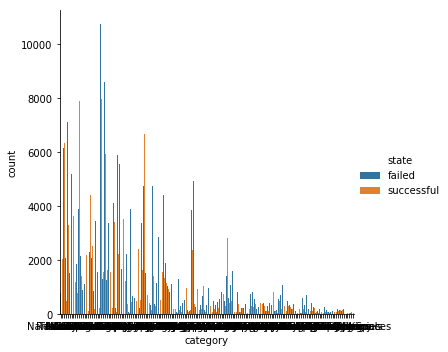

In [12]:
plt.figure(figsize=(20, 20))
sns.catplot(x="category", hue="state", data=df_cloud, kind="count", dodge=True)
plt.show()

In [13]:
# 'category'を全て表示
print(df_cloud['category'].value_counts(normalize=True, dropna=False))

Product Design        0.056353
Documentary           0.043815
Music                 0.037666
Tabletop Games        0.035431
Shorts                0.034375
Food                  0.031424
Video Games           0.028142
Film & Video          0.025948
Fiction               0.024461
Fashion               0.022714
Art                   0.022585
Nonfiction            0.022367
Theater               0.020165
Rock                  0.018844
Children's Books      0.018699
Apparel               0.018599
Technology            0.017266
Indie Rock            0.016077
Apps                  0.015950
Photography           0.015827
Webseries             0.015531
Publishing            0.015145
Narrative Film        0.013932
Comics                0.013820
Web                   0.013000
Country & Folk        0.012710
Crafts                0.012526
Design                0.010701
Hip-Hop               0.010435
Hardware              0.009395
Pop                   0.009205
Painting              0.009156
Illustra

<Figure size 1440x1440 with 0 Axes>

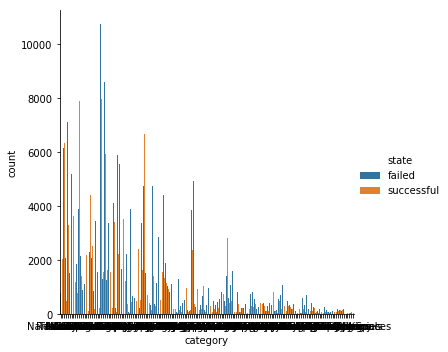

In [14]:
plt.figure(figsize=(20, 20))
sns.catplot(x="category", hue="state", data=df_cloud, kind="count", dodge=True)
plt.show()

In [15]:
# 'main_category'を全て表示
pd.set_option("display.max_rows", 200)
print(df_cloud['main_category'].value_counts(normalize=True, dropna=False))

Film & Video    0.170467
Music           0.138177
Publishing      0.106838
Games           0.086045
Technology      0.081595
Art             0.077357
Design          0.076518
Food            0.066535
Fashion         0.059656
Theater         0.030899
Comics          0.029801
Photography     0.029231
Crafts          0.023586
Journalism      0.012514
Dance           0.010779
Name: main_category, dtype: float64


<Figure size 1440x1440 with 0 Axes>

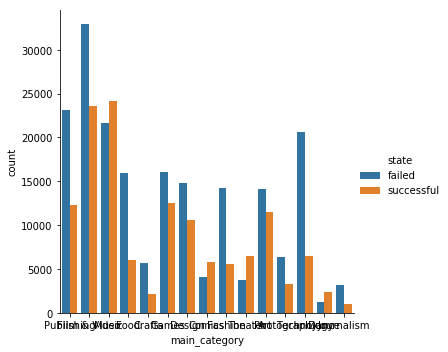

In [16]:
plt.figure(figsize=(20, 20))
sns.catplot(x="main_category", hue="state", data=df_cloud, kind="count", dodge=True)
plt.show()

In [17]:
#欠損値の確認
df_dummy.isnull().sum()

category               0
main_category          0
currency               0
goal                   0
pledged                0
state                  0
backers                0
country                0
usd pledged            0
usd_pledged_real       0
usd_goal_real          0
launched               0
deadline               0
state_num              0
dayofweek_Monday       0
dayofweek_Saturday     0
dayofweek_Sunday       0
dayofweek_Thursday     0
dayofweek_Tuesday      0
dayofweek_Wednesday    0
target growth rate     0
period                 0
dtype: int64

In [18]:
# 相関係数を確認
df_dummy.corr()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state_num,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,target growth rate,period
goal,1.000000,0.007962,0.004792,0.006416,0.005949,0.952614,0.025097,0.000081,-0.001565,-0.002116,0.001731,0.001591,-0.001329,-0.000458,0.022643
pledged,0.007962,1.000000,0.718120,0.857966,0.953465,0.005716,-0.109563,0.000095,-0.014843,-0.009131,-0.007338,0.030582,0.004914,0.008590,0.007795
backers,0.004792,0.718120,1.000000,0.697493,0.753221,0.005207,-0.125849,0.002679,-0.016068,-0.010604,-0.007591,0.030502,0.005146,0.016633,-0.000369
usd pledged,0.006416,0.857966,0.697493,1.000000,0.907713,0.006965,-0.095658,0.001368,-0.012083,-0.006593,-0.006567,0.022947,0.003731,0.006419,0.007530
usd_pledged_real,0.005949,0.953465,0.753221,0.907713,1.000000,0.006349,-0.108359,0.001237,-0.014810,-0.008980,-0.007868,0.030306,0.004432,0.008941,0.008314
usd_goal_real,0.952614,0.005716,0.005207,0.006965,0.006349,1.000000,0.023733,0.000473,-0.002020,-0.002104,0.001423,0.002257,-0.001868,-0.000433,0.021558
state_num,0.025097,-0.109563,-0.125849,-0.095658,-0.108359,0.023733,1.000000,-0.002543,0.018315,-0.000228,0.001415,-0.021992,-0.002198,-0.014710,0.116616
dayofweek_Monday,0.000081,0.000095,0.002679,0.001368,0.001237,0.000473,-0.002543,1.000000,-0.134603,-0.105933,-0.191513,-0.222107,-0.204384,0.001300,-0.008986
dayofweek_Saturday,-0.001565,-0.014843,-0.016068,-0.012083,-0.014810,-0.002020,0.018315,-0.134603,1.000000,-0.074130,-0.134018,-0.155427,-0.143025,-0.001665,0.013514
dayofweek_Sunday,-0.002116,-0.009131,-0.010604,-0.006593,-0.008980,-0.002104,-0.000228,-0.105933,-0.074130,1.000000,-0.105473,-0.122322,-0.112561,-0.000854,0.017992


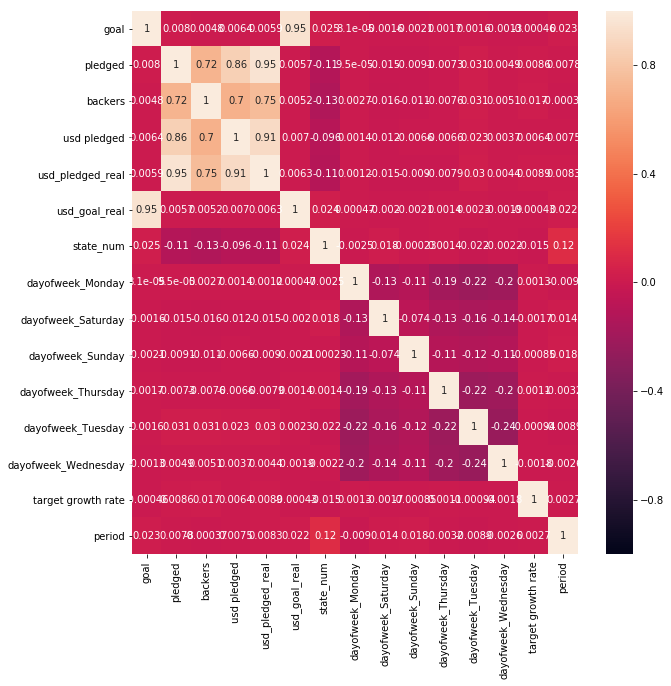

In [19]:
# 相関係数をヒートマップにして可視化
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_dummy.corr(), annot=True, vmax=1, vmin=-1,)
plt.show()

In [20]:
#評価対象のみに絞る
#df_eval = df_dummy.loc[:, ['state_num', 'target growth rate', 'period']]
df_eval = df_dummy.loc[:, ['state_num', 'dayofweek_Monday', 'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayofweek_Thursday', 'dayofweek_Saturday', 'dayofweek_Sunday', 'target growth rate', 'period']]

In [21]:
#不要データの削除
#del df_dummy
#del df_cloud

In [22]:
# 散布図行列を書いてみる
# pd.plotting.scatter_matrix(df_eval, figsize=(10,10))
# plt.show()

# 特徴選択

In [23]:
# estimatorにモデルをセット
# 今回は分類問題であるためロジスティック回帰を使用
estimator = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1111, tol=1e-3)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=2, scoring='accuracy')

In [24]:
train_label = df_eval["state_num"]
train_data = df_eval.drop('state_num', axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
rfecv.fit(X, y)

RFECV(cv=2,
   estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1111, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [25]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 3 1 2 1 4]


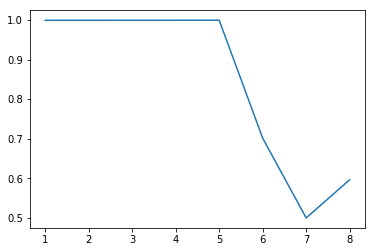

In [26]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [27]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([ True,  True,  True, False,  True, False,  True, False])

In [28]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([False, False, False,  True, False,  True, False,  True])

In [29]:
# 削除してもよい特徴の名前を取得する
remove_feature = train_data.columns[remove_idx]
remove_feature

Index(['dayofweek_Thursday', 'dayofweek_Sunday', 'period'], dtype='object')

In [30]:
# drop関数で特徴を削除
selected_train_data = train_data.drop(remove_feature, axis=1)
selected_train_data

,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Saturday,target growth rate
0,0,1,0,0,0.000000
1,0,0,0,1,0.080700
2,0,0,0,1,0.004889
3,0,0,0,1,0.000200
5,0,0,0,0,1.047500
6,1,0,0,0,1.205000
7,1,0,0,0,0.018120
10,1,0,0,0,0.000000
11,0,0,0,1,1.016000
12,0,1,0,0,0.000000


# ホールドアウト法

In [31]:
#データを8:2分割
y = df_eval["state_num"].values
#X = df_eval.drop('state_num', axis=1).values
X = selected_train_data.values

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [32]:
# 標準化
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

In [33]:
#ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1111, tol=1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}'.format(w0, w1, w2, w3, w4, w5))

w0 = -0.932, w1 = 0.019, w2 = -0.031, w3 = 0.010, w4 = 0.052, w5 = -119.124


In [34]:
# ラベルを予測
y_est_train = clf.predict(X_train)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_train)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_train)))

対数尤度 = -9.919
正答率 = 71.284%


In [35]:
# ラベルを予測
y_est_test = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_test)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_test)))

対数尤度 = -9.870
正答率 = 71.424%


In [36]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])

conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,7597,18944
正解 = 失敗,0,39752


In [37]:
# ラベルを予測
y_pred_test = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)

# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 71.424%
適合率（Precision） = 100.000%
再現率（Recall） = 28.624%
F1値（F1-score） = 44.508%


# 交差検証

In [38]:
y = df_eval["state_num"].values
#X = df_eval.drop('state_num', axis=1).values
X = selected_train_data.values

n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_logloss = 0
cross_valid_acc_score = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 標準化
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_test = stdsc.transform(X_test)
    
    # 学習用データを使ってロジスティック回帰モデルを学習
    clf2 = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1111, tol=1e-3)
    clf2.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf2.predict(X_test)
    
    # テストデータに対する対数尤度/正答率を計算
    # 対数尤度を表示
    logloss=- log_loss(y_test, y_pred_test)
    print('対数尤度 = {:.3f}'.format(logloss))

    # 正答率を表示
    acc_score = 100 * accuracy_score(y_test, y_pred_test)
    print('正答率 = {:.3f}%'.format(acc_score))
    print()
    
    cross_valid_logloss += logloss #後で平均を取るためにloglossを加算
    cross_valid_acc_score += acc_score #後で平均を取るためにaccを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_logloss = cross_valid_logloss / n_split
print("Cross Validation 対数尤度 = %s"%round(final_logloss, 3))
final_acc_score = cross_valid_acc_score / n_split
print("Cross Validation 正答率 = %s"%round(final_acc_score, 3))

対数尤度 = -9.779
正答率 = 71.686%

対数尤度 = -10.602
正答率 = 69.306%

対数尤度 = -11.234
正答率 = 67.476%

対数尤度 = -10.658
正答率 = 69.143%

対数尤度 = -11.454
正答率 = 66.837%

Cross Validation 対数尤度 = -10.745
Cross Validation 正答率 = 68.89


# アルゴリズムの変更


個人PCだとマシンパワーが足りず、グリッドサーチできなかったので、
会社の検証サーバを使用

In [39]:
#GPUを指定（指定方法あってる？？）
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [45]:
#y = df_eval["state_num"].values
#X = df_eval.drop('state_num', axis=1).values
y = df_eval["state_num"].values
X = selected_train_data.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#%%time
parameters = {'kernel':['rbf'], 'C':[5,10,15], 'gamma':[5,10,15]} # ここを編集する
model = SVC()
clf3 = GridSearchCV(model, parameters, cv=5)
clf3.fit(X_train, y_train)
print(clf3.best_params_, clf3.best_score_)

{'C': 10, 'gamma': 10, 'kernel': 'rbf'} 0.999905182631182


In [48]:
# SVMの実行
C = 10
gamma = 10
clf3 = SVC(C=C, kernel="rbf",gamma=gamma)
clf3.fit(X_train, y_train)

# 未知のデータを識別する
clf3.predict(X_test)

array([1., 1., 1., ..., 0., 0., 0.])

In [49]:
print("識別精度=",clf3.score(X_test, y_test))

識別精度= 0.9998793242156074


いい感じになった？

(参考：グリッドサーチ実行前の結果)
C = 5,
gamma = 5,
rbf,
識別精度= 0.9983105390185036